# パターンテンプレート：ロジスティック回帰（テキスト分析）

## 題材について

In [1]:
# 概要
# (1)大量（56万行）のWiki文章を解析し、毒舌の種類に応じてクラス分けする。
# (2)TfidfVectorizer（文章内に出現する単語の出現頻度と希少性の2ファクター
#   を用いたクラス分類アルゴリズム）が使われている。
# 
# 題材のURL
#  https://www.kaggle.com/tunguz/logistic-regression-with-words-and-char-n-grams
# 

## ライブラリロード

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

from scipy.sparse import hstack

%matplotlib inline

## データの取り込みとデータ構造の確認

In [3]:
train_df = pd.read_csv('./train_light.csv').fillna(' ')
test_df = pd.read_csv('./test_light.csv').fillna(' ')

### 取り込み直後のデータ構造

In [4]:
train_df.info(max_cols=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7512 entries, 0 to 7511
Data columns (total 8 columns):
id               7512 non-null object
comment_text     7512 non-null object
toxic            7512 non-null int64
severe_toxic     7512 non-null int64
obscene          7512 non-null int64
threat           7512 non-null int64
insult           7512 non-null int64
identity_hate    7512 non-null int64
dtypes: int64(6), object(2)
memory usage: 469.6+ KB


In [5]:
test_df.info(max_cols=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4367 entries, 0 to 4366
Data columns (total 2 columns):
id              4367 non-null object
comment_text    4367 non-null object
dtypes: object(2)
memory usage: 68.3+ KB


### 変数の説明

In [6]:
%%html
<style>table {float: left}</style>

|変数名|値|
|---|---|
|id|主キー|
|toxic|毒舌ワード（1:あり  0:なし）|
|severe_toxic|毒舌ワード（1:あり  0:なし）|
|obscene|程度の強い毒舌ワード（1:あり  0:なし）|
|threat|卑猥ワード（1:あり  0:なし）|
|threat|脅しワード（1:あり  0:なし）|
|insult|屈辱ワード（1:あり  0:なし）|
|identity_hate|同一性嫌悪ワード（1:あり  0:なし）|




## データ観察

In [7]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \r\n\r\n The title is fine as i...
2,00013b17ad220c46,""" \r\n\r\n == Sources == \r\n\r\n * Zawe Ashto..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [9]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,7512.000000,7512.00000,7512.000000,7512.000000,7512.000000,7512.000000
mean,0.100772,0.01025,0.054979,0.003727,0.051384,0.009185
std,0.301047,0.10073,0.227954,0.060942,0.220795,0.095405
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [10]:
test_df.describe()

,id,comment_text
count,4367,4367
unique,4367,4367
top,0352bc79ff7715e3,WikiProject Anime and manga|class=Stub|importa...
freq,1,1


#### 数値データの可視化

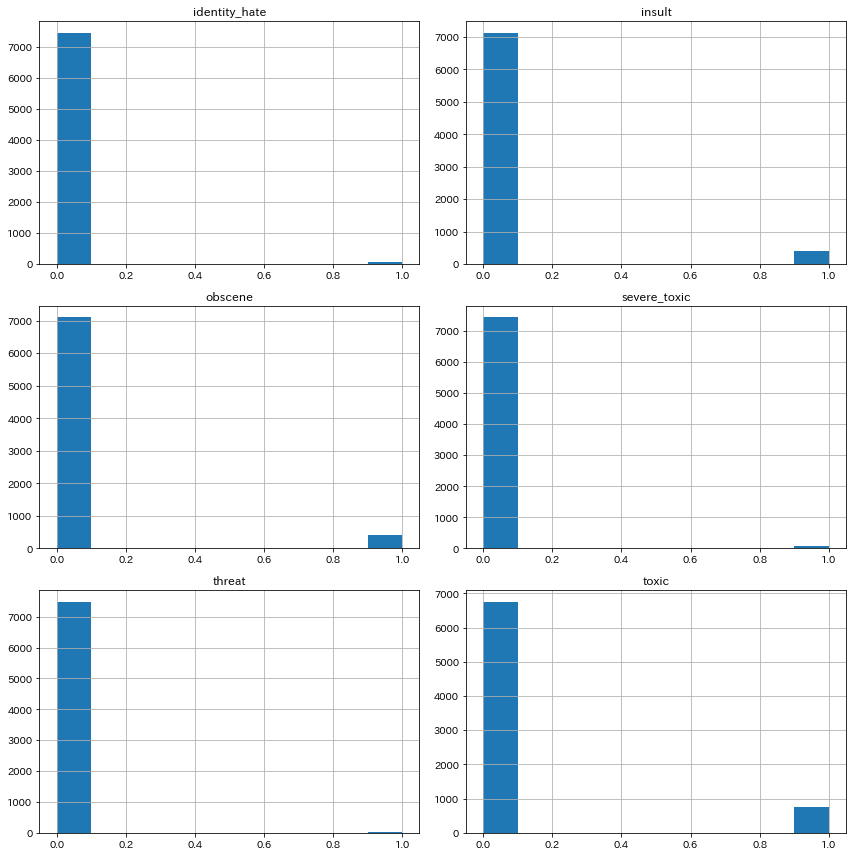

In [11]:
train_df.hist(figsize=(12, 12))
plt.tight_layout()
plt.show()

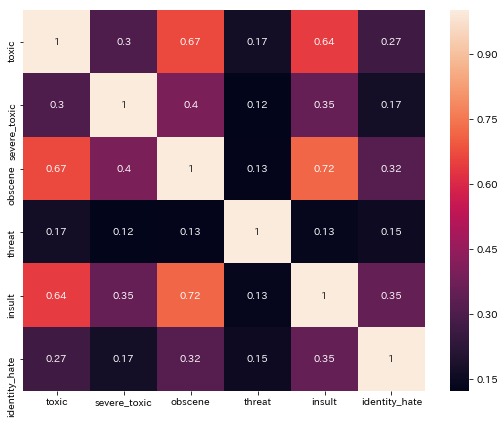

In [12]:
plt.figure(figsize=(9, 7)) 
sns.heatmap(train_df.corr(),annot=True)

In [13]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train_text = train_df['comment_text']
test_text = test_df['comment_text']
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',  # tokenize only words of 1+ chars
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)



In [14]:
train_word_features

<7512x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 176689 stored elements in Compressed Sparse Row format>

In [15]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])



In [16]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

scores = []
submission = pd.DataFrame.from_dict({'id': test_df['id']})
for class_name in class_names:
    train_target = train_df[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1]

print('Total CV score is {}'.format(np.mean(scores)))

submission.to_csv('submission.csv', index=False)

CV score for class toxic is 0.9397273912381884
CV score for class severe_toxic is 0.9774409344280328
CV score for class obscene is 0.9677640085543202
CV score for class threat is 0.9770220389693819
CV score for class insult is 0.9571098867202328
CV score for class identity_hate is 0.9516148817973118
Total CV score is 0.9617798569512447
